In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
df = pd.read_table('log.intEnergy')
df.head()

FileNotFoundError: File b'log.intEnergy' does not exist

In [87]:
fileName = "log.intEnergy"
runNum = 1

search = "Step"
n = 1
f = open(fileName)
df = {}
EOF = False
while True:
    try:
        line = f.readline()
    except:
        break
    if search in line:
        if n == runNum:
            keys = line.split()
            for key in keys:
                df[key] = []
            while True:
                try:
                    line = f.readline()
                except:
                    EOF = True
                    break
                try:
                    values = list(float(x) for x in line.split())
                except:
                    break
                for i in range(len(keys)):
                    df[keys[i]].append(values[i])
        else:
            n += 1
    else:
        pass
    if len(df.keys()) > 0 or EOF:
        break
df = pd.DataFrame(df)
f.close()
print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'log.intEnergy'

# Working Log file Reader 

test code for class


In [88]:
filename = 'log.interfaceTracking'   #takes in filename
thermoLabels = 'Step Atoms Temp Press TotEng'.split()    #take in thermo output Labels/arguements
includeLabelsForNewRun = False

dataLines = []

f = open(filename,'r')
data = False
for line in f.readlines():
    #print(line.split())
    
    if data:
        if len(line.split())!= 0 and line.split()[0].isdigit():
            dataLines.append(line.split())
        else:
            data = False
    
    if line.split() == thermoLabels:
        data = True
        if includeLabelsForNewRun:
            dataLines.append(line.split())
    
f.close()

for i in dataLines:
    print(i)

#print(outputLabels)

In [89]:
df = pd.DataFrame(dataLines,columns=thermoLabels)
#print(df)

Actual Reader Class

In [90]:
class LogReader:
    def __init__(self,filename,thermoLabels):
        self.var = "holder"
        self.filename = filename
        self.thermoLabels = thermoLabels.split()
    
    # get lines of thermo output data as list of lines
    def dataExtracter(self,includeLabelsForNewRun=False):
        self.includeLabelsForNewRun = includeLabelsForNewRun

        dataLines = []
        
        f = open(filename,'r')
        isDataLine = False
        for line in f.readlines():
            if isDataLine:
                if len(line.split())!= 0 and line.split()[0].isdigit():
                    dataLines.append(line.split())
                else:
                    isDataLine = False
            
            if line.split() == self.thermoLabels:
                isDataLine = True
                if includeLabelsForNewRun:     #used to seperate runs by thermoLabels
                    dataLines.append(line.split())

        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataFrame(self,seperateRunsByThermoLabels=False):
        return pd.DataFrame(self.dataExtracter(seperateRunsByThermoLabels),columns=self.thermoLabels)

In [91]:
reader = LogReader('log.Bulkmod','Step Atoms Temp Press TotEng')
df = reader.getDataFrame()
print(reader.getDataFrame())

Empty DataFrame
Columns: [Step, Atoms, Temp, Press, TotEng]
Index: []


# Working Grapher

In [92]:
import numpy as np
import matplotlib.pyplot as plt

#collection of methods that analyze dataframe data
class LogAnalyzer:
    def __init__(self,dataframe,timestep=1):
        self.df = dataframe
        self.timestep = timestep
        
    def generalPlot(self,X,Y,xlabel='',ylabel='',title=''):
        plt.plot(X,Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        #plt.legend(loc='upper left')
        plt.grid()
        plt.show()
        
    def plotColumn(self,columnLabel):
        Y = self.df[columnLabel].values.astype(float)
        X = np.linspace(0,self.timestep*len(Y),len(Y))
        self.generalPlot(X,Y,'Runtime',columnLabel)

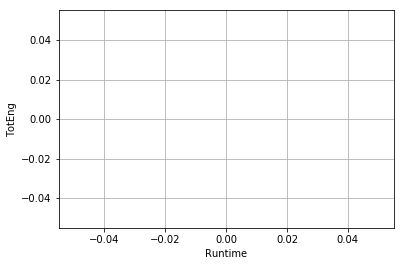

In [93]:
LA = LogAnalyzer(df)
LA.plotColumn('TotEng')


# Reading position vectors from dump files; Working DumpReader class



#implementation assumes that atom ids are in same order for each run, seems to be the case need to confirm 

In [104]:

class DumpReader:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        data = self.dataExtracter()
        for row in range(len(data)):
            #data[row] = np.array(data[row])
            for col in range(len(data[row])):
                data[row][col] = np.array(data[row][col]).astype(float)
        return np.array(data)
'''
note, tried to build dataLines as np.array but since i consistently appending new data to rowData i 
have to make a new copy and reassign (very wasteful) 
instead trying building dataLines then converting elements to np.array by looping, (is there a more efficient
way to do this?)

'''


'\nnote, tried to build dataLines as np.array but since i consistently appending new data to rowData i \nhave to make a new copy and reassign (very wasteful) \ninstead trying building dataLines then converting elements to np.array by looping, (is there a more efficient\nway to do this?)\n\n'

code for testing/proof of concept 

In [223]:
#outputLabels = 'id x y z'
DR = DumpReader('atomParameters.data','id type c_ptm[1] c_ptm[2] c_ptm[3] c_centro')
df = DR.getDataframe()
data = DR.getNdArray()

atomNum = 1
atom1Data = np.array([np.array(i) for i in data[:,atomNum]])  # use this to get atom i data as shape (runs,parameters)

print(atom1Data)
#print(pd.DataFrame(data[None,:,1]))

[[ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      0.         inf  0.     19.7653]
 [ 1.      

In [107]:
names = ['Timestep','1r','2r','3r']
a = [[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]]
ar = np.array([[[10],[1,2,3],[1,2,3],[1,2,3]],
         [[20],[1,2,3],[1,2,3],[1,2,3]],
         [[30],[1,2,3],[1,2,3],[1,2,3]],
         [[40],[1,2,3],[1,2,3],[1,2,3]]])
pd.DataFrame(ar,columns = names)

ar2 = np.array([])

for row in a:
    r = np.array([])
    for elem in row:
        np.append(r,np.array(elem))
        
    np.append(ar2,r)



In [137]:
a= np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a[:][0])
print(a[:,0])


[1 2 3]
[1 4 7]
[1 2 3]


# Edditable DumpReader2 class to implemented data extraction using ndarrays


In [97]:

class DumpReader2:
    def __init__(self,filename, outputLabels = ''):
        self.filename = filename
        self.outputLabels = ('ITEM: ATOMS '+ outputLabels).split()
    
    def dataExtracter(self):
        dataLines = []         # format : [[rowData1], [rowData2], [rowData3], ... ]
        self.idLabels = ['Timestep']      # format : ['Timestep', 'atomID', 'atomID', ... ]
        rowData = []                      # format : [[timestep], [x,y,z], [x,y,z], ... ]
        
        f = open(self.filename,'r')
        isFirstRun = True
        isDataLine = False          # when initially set, line in next iteration is a data line
        isTimestepLine = False      # when initially set, line in next iteration is a timestep line
        timestep = 0
        
        for line in f.readlines():  
            if line.strip() == 'ITEM: TIMESTEP' or isTimestepLine:
                if isTimestepLine:
                    isTimestepLine = False
                    timestep = int(line.split()[0])
                    rowData.append([timestep])
                    if timestep > 0:                 #assumes simulation starts at 0 timestep
                        isFirstRun = False
                else:
                    isTimestepLine = True
            
            if isDataLine:  
                data = line.split()
                if len(line.split())!= 0 and data[0].isdigit():   
                    if isFirstRun: 
                        self.idLabels.append(data[0])   # append label
                    rowData.append(line.split()[1:])   
                else:
                    isDataLine = False
                    dataLines.append(rowData)
                    rowData = []
            
            if line.split() == self.outputLabels:    
                isDataLine = True                     
                
        f.close()
        return dataLines

    #User method to get dataframe from log data
    def getDataframe(self):
        return pd.DataFrame(self.dataExtracter(),columns=self.idLabels)
    
    def getNdArray(self):
        return self.dataExtracter()
        



In [98]:
r = [[1],[1,2,3],[1,2,3]]
a = np.empty(0)
a = np.append(a,np.array([1,2,3]))
b = np.asarray(r)
for i in range(len(b)):
    b[i] = np.array(b[0])
    
print(b)

[array([1]) array([1]) array([1])]


# Function to check for convergence of data to a certain value; method of DataFileAnalyzer class


In [99]:
    import copy 
    
    def getConstValueList(self,columnLabel):
        yData = np.array(self.df[columnLabel].tolist())   # GET COLUMN DATA AS TARGET NDARRAY
        yGradient = np.gradient(yData)
        print(yGradient)
        
        
        #how to decide maxError?, minRange?
        
    def getConstValueList2(df,columnLabel,timestepInterval=10,maxError=1,minRange=50):
        #thermo data is outputedevrey timestepInterval
        
        yData = np.array(df[columnLabel].tolist()).astype(float)   # GET COLUMN DATA AS TARGET NDARRAY
        #plt.plot(yData)
        yGradient = np.gradient(yData)     # timestep is conserved
        plt.plot(yGradient[20:])
        yGGradient = np.gradient(yGradient)   # timestep is conserved
        plt.plot(yGGradient[20:])
        
        #print(yData.shape,'   ',yGradient.shape,'   ',yGGradient.shape)
        
        constValueRanges= []
        
        lowRange, uppRange = -1, -1    # -1 means var is not set
        

        for ind in range(yGGradient.shape[0]):
            #print(ind,' ',yGGradient[ind], " low: ",lowRange," upp: ",uppRange,' cond: ',(uppRange == -1) and abs(yGradient[ind]) < maxError)
            if lowRange != -1 and abs(yGGradient[ind]) < maxError:  # if lowRange is set, then can set uppRnge
                uppRange = ind
                if ind == (yGGradient.shape[0]-1):
                    constValueRanges.append([lowRange,uppRange])
            elif lowRange != -1 and uppRange != -1:
                if abs(uppRange-lowRange) > minRange:
                    #print(ind,' ',yGradient[ind], " low: ",lowRange," upp: ",uppRange)
                    constValueRanges.append([lowRange,uppRange])
                lowRange = -1
                uppRange = -1   
                
            
            if (uppRange == -1):       # if uppRange is not set then can set lowRange
                lowRange = ind
        
        print(constValueRanges)
        return constValueRanges
    
# energy = np.mean(yData[constValueRange[0],constValueRange[1]])
        
    
       
        

In [100]:
 yData = np.array(df['TotEng'].tolist()).astype(float)

# have to find a decent way to find max Error (and alittle, but its fine rn,the min Range value)
def getConstValueList3(df,columnLabel,timestepInterval=10,maxError=1,minRange=10):
        #thermo data is outputedevrey timestepInterval
        
        yData = np.array(df[columnLabel].tolist()).astype(float)   # GET COLUMN DATA AS TARGET NDARRAY
        #plt.plot(yData)
        yGradient = np.gradient(yData)     # timestep is conserved
        #plt.plot(yGradient[20:])
        yGGradient = np.gradient(yGradient)   # timestep is conserved
        #plt.plot(yGGradient[20:])
        
        #print(yData.shape,'   ',yGradient.shape,'   ',yGGradient.shape)
        
        constValueRanges= []
        
        lowRange, uppRange = -1, -1    # -1 means var is not set
        

        for ind in range(yGGradient.shape[0]):
            #print(ind,' ',yGGradient[ind], " low: ",lowRange," upp: ",uppRange,' cond: ',(uppRange == -1) and abs(yGradient[ind]) < maxError)
            if lowRange != -1 and abs(yGGradient[ind]) < maxError:  # if lowRange is set, then can set uppRnge
                uppRange = ind
                if ind == (yGGradient.shape[0]-1):
                    constValueRanges.append([lowRange,uppRange])
            elif lowRange != -1 and uppRange != -1:
                if abs(uppRange-lowRange) > minRange and np.mean(yGradient[lowRange:uppRange])<maxError:
                    #print(ind,' ',yGradient[ind], " low: ",lowRange," upp: ",uppRange)
                    constValueRanges.append([lowRange,uppRange])
                lowRange = -1
                uppRange = -1   
                
            
            if (uppRange == -1):       # if uppRange is not set then can set lowRange
                lowRange = ind
                
                
        #STD ANALYSIS
        yStd =[]
        for ind in range(yData.shape[0]):
            if ind == 0 or ind == 1:
                yStd.append(np.std([yData[ind],yData[ind+1]]))
            elif ind == yData.shape[0]-1 or ind == yData.shape[0]-2:
                yStd.append(np.std([yData[ind],yData[ind-1]]))
            else:
                yStd.append(np.std([yData[ind-2],yData[ind-1],yData[ind],yData[ind+1],yData[ind-2]]))
        plt.plot(yStd[10:])
            
            
        
        print(constValueRanges)
        
        
        
        return constValueRanges

KeyError: 'TotEng'

In [101]:
lst = getConstValueList3(df,'TotEng')

'''
yData = np.array(df['TotEng'].tolist()).astype(float)[10:]

subData = []
for rang in lst:
    subData.append(yData[rang[0]:rang[1]+1])
    
for subD in subData:
    abc = getConstValueList2(pd.DataFrame(subD,columns=['ySubData']),'ySubData')
    #dftest = pd.DataFrame(subD,columns=['ySubData'])
    #print(dftest['ySubData'])
    print()
'''

KeyError: 'TotEng'

In [102]:
yData = np.array(df['TotEng'].tolist()).astype(float)[10:]   # GET COLUMN DATA AS TARGET NDARRAY
plt.plot(yData)

#lst.append([11,146])

for rang in lst:
    y=np.ones(rang[1]-rang[0]+1)*np.mean(yData[rang[0]:rang[1]])
    plt.plot(np.arange(rang[0],rang[1]+1),y)
    #print(y)


KeyError: 'TotEng'

(0,) (0,) (1, 0) (0,) (0,) (2, 0) (0,)


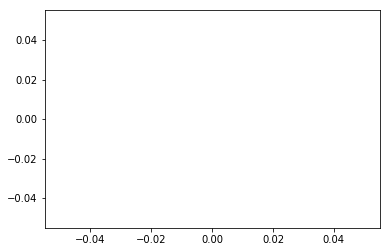

In [103]:
#Y is vector of data

dataBin = 1 #ORANGE
binDivisibleY = yData[yData.shape[0]%dataBin:]

binnedY = binDivisibleY[None,:].reshape(dataBin,int(binDivisibleY.shape[0]/dataBin)) #binned data is along column
meanBinnedY = np.mean(binnedY,axis=0)

stdBin = 2 #GREENE
binDivisibleMeanY = meanBinnedY[meanBinnedY.shape[0]%stdBin:]
binnedMeanY = binDivisibleMeanY[None,:].reshape(stdBin,int(binDivisibleMeanY.shape[0]/stdBin)) #binned data is along column
stdBinnedMeanY = np.std(binnedMeanY,axis=0)

print(yData.shape,binDivisibleY.shape,binnedY.shape,meanBinnedY.shape, binDivisibleMeanY.shape,binnedMeanY.shape,stdBinnedMeanY.shape)

#plt.plot(yData)
plt.plot(meanBinnedY)
plt.plot(stdBinnedMeanY)
              

